# Lab3 part2 - Time Frequency


In [3]:
# Import functions and libraries
from __future__ import division
import numpy as np, matplotlib.pyplot as plt
from numpy import *
from numpy.fft import *
import scipy.signal as signal
from matplotlib.pyplot import *
from scipy.ndimage.interpolation import shift

from rtlsdr import RtlSdr

import scipy
import scipy.io
from scipy.io.wavfile import write
%matplotlib inline

Below are some functions from Part I that we will need in this part

In [4]:
# Plot an image of the spectrogram y, with the axis labeled with time tl,
# and frequency fl
#
# t_range -- time axis label, nt samples
# f_range -- frequency axis label, nf samples
# y -- spectrogram, nf by nt array
# dbf -- Dynamic range of the spectrum

def sg_plot( t_range, f_range, y, dbf = 60, fig = None) :
    eps = 10.0**(-dbf/20.0)  # minimum signal
    
    # find maximum
    y_max = abs(y).max()
    
    # compute 20*log magnitude, scaled to the max
    y_log = 20.0 * np.log10( (abs( y ) / y_max)*(1-eps) + eps )
    
    # rescale image intensity to 256
    img = 256*(y_log + dbf)/dbf - 1
    
 
    fig=figure(figsize=(16,6))
    
    plt.imshow( np.flipud( 64.0*(y_log + dbf)/dbf ), extent= t_range  + f_range ,cmap=plt.cm.gray, aspect='auto')
    plt.xlabel('Time, s')
    plt.ylabel('Frequency, Hz')
    plt.tight_layout()
    
    return fig

In [5]:
import pyaudio
import wave

# function that reads wav file to array
def read_wav( wavname ):
    
    wf = wave.open(wavname, 'rb')
    
    CHUNK = 1024
    frames = []
    data_str = wf.readframes(CHUNK) #read a chunk
    
    while data_str != '':
        data_int = np.fromstring( data_str, 'int16') # convert from string to int (assumes .wav in int16)
        data_flt = data_int.astype( np.float32 ) / 32767.0 # convert from int to float32
        frames.append( data_flt )  #append to list
        data_str = wf.readframes(CHUNK) #read a chunk

    return np.concatenate( frames )


def play_audio( data, p, fs):
    # data - audio data array
    # p    - pyAudio object
    # fs    - sampling rate
    
    # open output stream
    ostream = p.open(format=pyaudio.paFloat32, channels=1, rate=fs,output=True)
    # play audio
    ostream.write( data.astype(np.float32).tostring() )

## Part II: Broadcast FM Radio


### Task 5: Time-Frequency plots of the radio-frequency spectrum with the SDR.

### Solution:

We will first look at radio FM spectrum. In the US the broadcast FM radio band is  88.1-107.9Mhz. It is split into  200KHz slots. This is relatively a large bandwidth and therefore it is also called wideband FM as opposed to narrowband FM which can be as low as 5 Khz.  In FM radio the information is encoded by modulating the frequency of the carrier,  
$$y_c(t) = A\cos \left (2\pi f_c t + 2\pi \Delta f \int_0^t x(\tau) d\tau \right ).$$

Here, $f_c$ is the carrier frequency,  $\Delta f$ is the frequency deviation and $x(t)$ is a normalized baseband signal, which contains all the information the station wants to broadcast. This includes stereo audio, as well as digital information on the station and sometimes additional narrow bandwidth subcarrier channels. 



More specifically, the broadcast FM baseband signal, $x(t)$, consists of mono (Left+Right) channels from 30Hz to 15 KHz, a pilot signal at $f_p=19$ KHz, amplitude modulated Stereo (Left - Right) channels around $2\cdot f_p =  38$KHz and digital RBDS, which encodes the station information, song name etc.  at $3\cdot f_p =57$KHz.  (See <http://en.wikipedia.org/wiki/FM_broadcasting> for more information). 

The baseband signal is:

$ \qquad \qquad x(t) = \underbrace{(L+R)}_{\mathrm{mono}} + \underbrace{0.1 \cdot \cos(2\pi f_p t)}_\mathrm{pilot} +  \underbrace{(L-R)\cos(2\pi (2f_p) t)}_\mathrm{stereo}  + \underbrace{0.05\cdot \mathrm{RBDS}(t)\cos(2\pi (3f_p) t)}_\mathrm{digital~ RBDS} + \mathrm{subcarriers~signals}. $

The signal $\mathrm{RBDS}(t)$ is a $m(t)\cos(2\pi(3(f_p))$ where $m(t)$ is a binary signal consists of $\pm1$ at constant intervals which encode 0, and 1 bits. The subcarriers are often FM modulated signals of foreign stations or carry other information.
This is the spectrum of $x(t)$:

<center><img src="https://inst.eecs.berkeley.edu/~ee123/sp14/lab/lab2/FM.pdf" alt="FM" style="width: 800px;"/></center>


We will listen to our Berkeley own KPFA 94.1MHz station. KPFA transmitter is located close to Grizzly Peak Road, close to where it meets Claremont Ave.


Recall that our SDR does IQ demodulation around a center frequency of choice, $f_d$, followed by a low-pass filter and sampling. This results in a complex digital signal: $$\qquad \qquad y_b(t) = Ae^{j2\pi (f_c-f_d) t + j2\pi \Delta f \int_0^t x(\tau) d\tau }.$$

When $f_d=f_c$ we get:
$$\qquad \qquad y_b(t) = Ae^{ j2\pi \Delta f \int_0^t x(\tau) d\tau }.$$

We will implement the following system to demodulate and listen to KPFA:
<center><img src="https://inst.eecs.berkeley.edu/~ee123/sp16/lab/lab3/fmdemod_LPR.png" alt="FM" style="width: 800px;"/></center>

The samples that are obtained by the SDR represent a bandwidth of the spectrum around a center frequency. Hence, when demodulating to base-band (i.e. zero frequency) the signal must be imaginary since it has a non symmetric Fourier transform. 

In this case, we would like to display both sides of the spectrum.

- Modify the function `myspectrogram_hann_ovlp(x,m,fs,fc)` such that it detects whether the input signal `x` is complex. In that case, it will compute a double sided spectrum with frequency range centered around fc (center frequency). For this, it would be useful to use the commands: `isreal` and `fftshift`.


#### Signal Capture:

Like always, you will get the best results if you collect samples outside. 


Task: 
- Set the SDR to sample at a center frequency of 94.1MHz (KPFA) and a rate of 2.4MHz. We will first collect 1*2560000 samples, which is just over 1 seconds of data. We acquire only one second  because computing a spectrogram on more data make take a while on some computers. 
- Compute and display a spectrogram with a window of 1024 samples. Include the spectrogram in your report. 
## What is the spectral and temporal resolution? Explain what you see.
## Temporal res = ([window size]/[samples])/[rate] = (1024/2560000)/fs = 1.67e-10 s
## Spectral res = fs/[window size] = fs/1024 = 2.4 MHz/1024 = 2343.75 Hz
## Looking at the raw data, I can see three different stations - the top one looks like voice, middle music, bottom also voice. We can see that the top station has additional bands around the FM signal (possible digital?), and that the bottommost signal is the weakest. 
Tips:
- Don’t forget to play with different dynamic ranges of the spectrogram for best visualization. (30 worked well for me)
- Make sure to set the gain of the SDR so the signal is not under/overloaded! This will make a HUGE difference when demodulating the carriers.

In [63]:
fs = 2400000
fc = 94.1e6
sdr = RtlSdr()
sdr.sample_rate = fs    # sampling rate
sdr.center_freq = fc   # center frequency
sdr.gain = 30.0
N_Samples = 2560000
data = sdr.read_samples(N_Samples)   # get samples
sdr.close()

In [64]:
def myspectrogram_hann_ovlp(x, m, fs, fc, dbf = 60, fig = None):
    # Plot the spectrogram of x.
    
    xreal = np.isreal(x).all()
    lx = len(x)
    M = ceil(lx/m)*m
    
    x = np.append(x, zeros(M - lx))
    x = np.reshape(x, (m/2, 2*M/m), order='F')
    x = np.vstack((x,x))
    x = np.ndarray.flatten(x.T)
    x[0:m/2] = 0
    x = np.roll(x,-m//2)
    x = np.reshape(x,(m,len(x)/m),order='F')

    f_range = [0.0, fs / 2.0]
    t_range = [0.0, lx / fs]
    
    xm = x * hanning(m)[:,None] # Hanning window
    xmf = np.fft.fft(xm,len(xm),axis=0)
    
    if not xreal:
        print('c')
        xmfs = np.fft.fftshift(xmf, axes = 0)
        f_range = [fc - fs/2.0, fc + fs/2.0]
        sg_plot(t_range,f_range, xmfs, dbf=dbf)
        return
    
    sg_plot(t_range,f_range,xmf[:m/2,:])

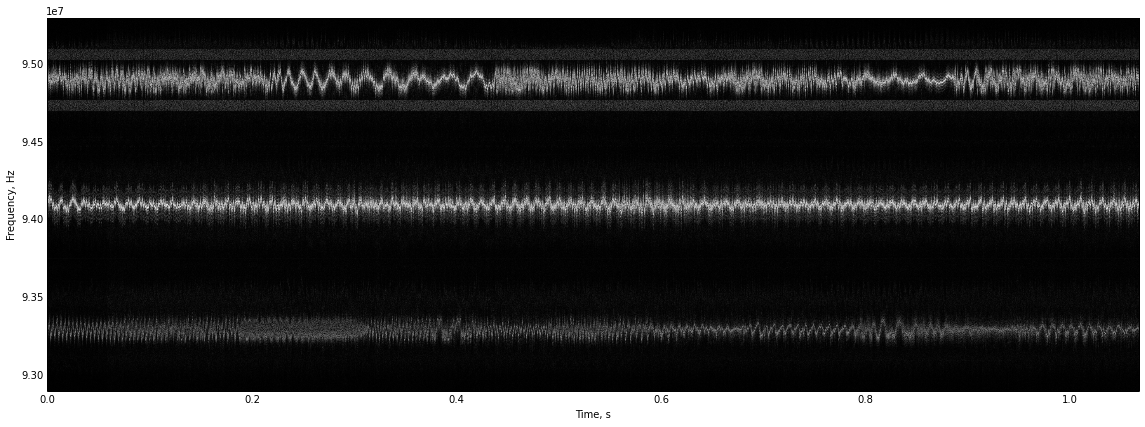

In [218]:
# Plot. Plotting may take a while!
fig = myspectrogram_hann_ovlp(data, 1024, fs, fc, dbf=35)

#### Downsampling:

The bandwidth of an FM station is 200KHz. Since we sampled at 2.4MHz, you should be seeing several stations in the spectrogram: at 93.3MHz, 94.1MHz and 94.9MHz. KPFA, the station we are interested in is in the middle around 94.1MHz.  We will need to filter out and select the desired station from the rest of the signals within the spectrum. 

Task:
- Design an FIR filter low-pass filter. The filter should be of  length 513 and the cutoff frequency be 100KHz. This will select the frequencies between -100KHz to 100KHz. To design the filter, we will use the function `signal.firwin` (We will talk more about this filter design technique later in class -- but in essence the function creates a windowed sinc function with the appropriate bandwidth for the given length). 
Type `signal.firwin?` and execute to get help. 

    h = signal.firwin(513,100000.0,nyq=2400000.0/2,window='hanning')

- Plot the double-sided magnitude frequency response (log scale using `plt.semilogy`) by computing a zero-padded FFT to length 1024 and using fftshift. Use KHz as the x-axis units. 




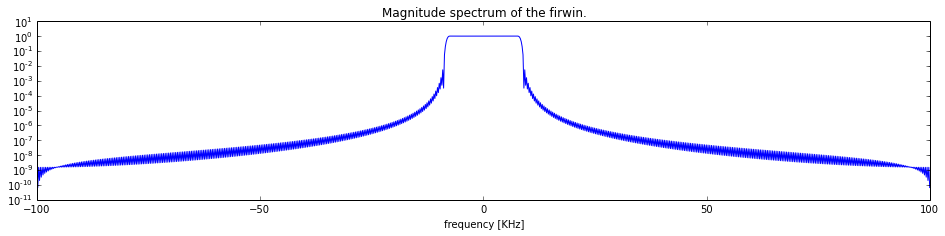

In [66]:
# Your code here:
h = signal.firwin(513,100000.0,nyq=2400000.0/2,window='hanning')
h = append(h,zeros(1024-len(h)))

H = np.fft.fft(h)
sH = np.fft.fftshift(H)

f = np.linspace(-100000, 100000, len(H))

# Plot
width, height = figaspect(0.2)
fig=plt.figure(figsize=(width,height))
plt.semilogy(f/1e3, abs(sH)), plt.xlabel('frequency [KHz]');
# plt.plot(np.abs(sH))
plt.title('Magnitude spectrum of the firwin.');

Now, filter the acquired SDR signal with the low-pass filter. Use the function `signal.fftconvolve`, which uses the FFT to perform fast convolution. Plot the spectrogram of the filtered signal. 

In [67]:
# Your code here:
filtered_data = signal.fftconvolve(data, h)

c


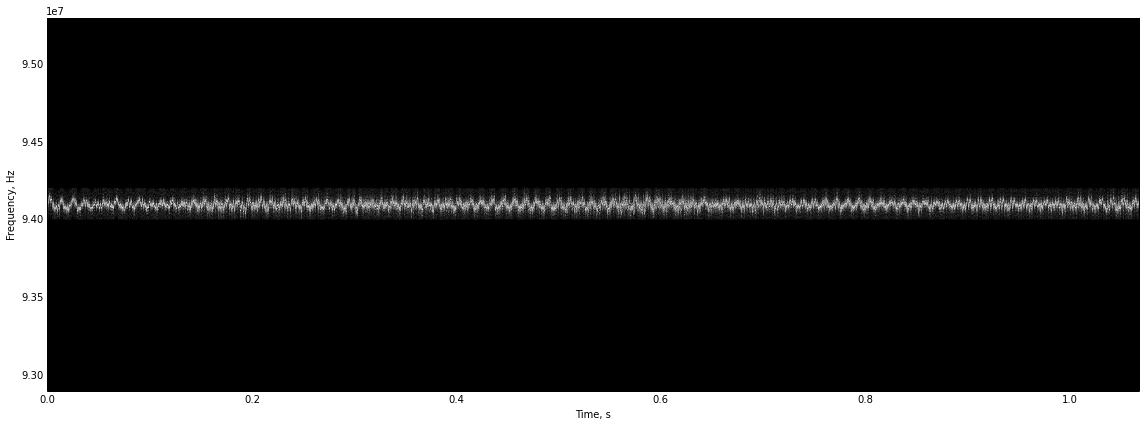

In [68]:
# Your code here:
fig = myspectrogram_hann_ovlp(filtered_data, 1024, fs, fc,dbf=30)

Our signal is now bandlimited with a bandwidth of 200KHz out of 2.4MHz. We can now downsample the signal to reduce computation without aliasing. 

- Decimate the signal by a factor of 10 by selecting every 10th sample, to get a signal representing a rate of 240KHz. After that, you have successfully implemented a downsampler through low-pass filtering and decimation! 

- Plot the spectrogram with a window size of 512. Remember to use the new sampling factor `fs/10.0` for the spectrogram.
## - Do you see the rolloff of the low-pass fiter? Is there aliasing?
## The rolloff of the LPF is very faint. It looks like the filter did its job -- the quickly fades to black, without any apparent aliasing.


In [69]:
# Your code here:
ds_data = filtered_data[::10]

c


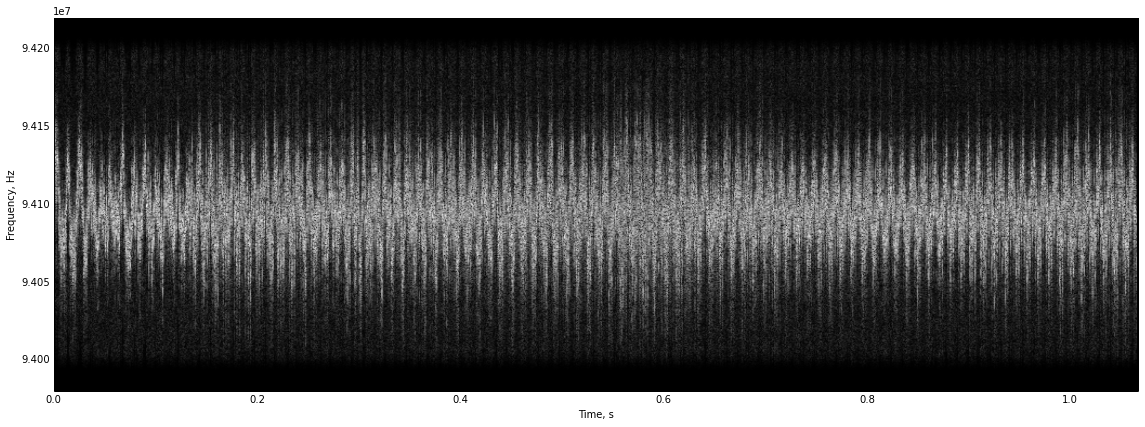

In [70]:
fig = myspectrogram_hann_ovlp(ds_data, 512, fs/10, fc,dbf=30)

Now that you have gone through this processing with 1 second worth of data.  We will acquire a longer segment, which will allow you to appreciate the audio that comes out of it once we demodulate it 

- Acquire 2560000*10 samples, which is just over 10 seconds of data
- Filter and decimate (hence downsample) to the rate of 240KHz
- Plot the spectrogram


In [71]:
# Your code here:
fs = 2400000
fc = 94.1e6
sdr = RtlSdr()
sdr.sample_rate = fs    # sampling rate
sdr.center_freq = fc   # center frequency
sdr.gain = 30.0
N_Samples = 2560000*10
data = sdr.read_samples(N_Samples)   # get samples
sdr.close()

In [72]:
filtered_data = signal.fftconvolve(data, h)
ds_data = filtered_data[::10]

c


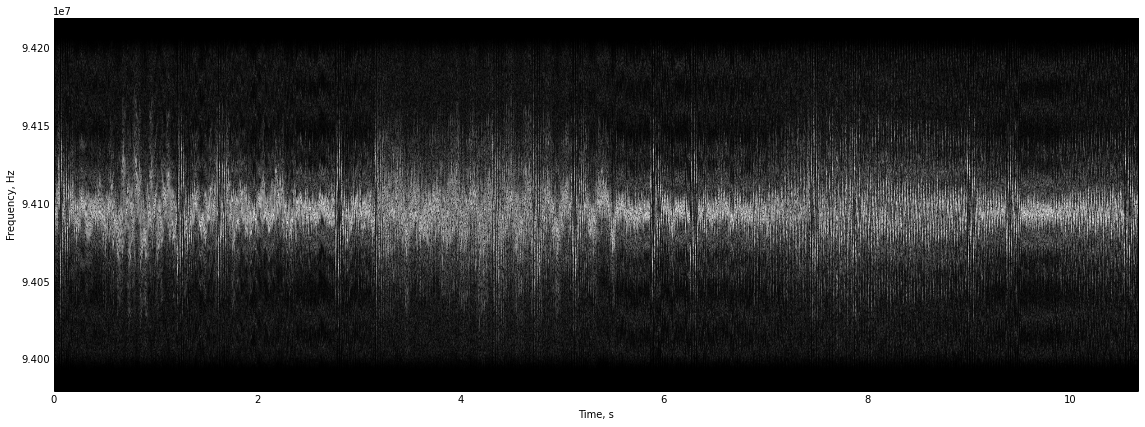

In [73]:
fig = myspectrogram_hann_ovlp(ds_data, 512, fs/10, fc,dbf=30)

#### FM Demodulation:

The plot does not resemble the broadcast FM spectrum figure above, since it is not yet FM demodulated. We can easily see that the signal is frequency modulated -- because its frequency looks like the time-signal of  speech or music.

The next step we are going to perform is to demodulate the FM signal and look at its spectrogram. For this we need to find the instantaneous frequency as a function of time, which is the time derivative of the phase. Computing the phase and then taking the derivative will be sensitive to phase wraps, which we would like to avoid. 


Instead, we will take the digital implementation version of the classical FM demodulatation using a limiter, followed by a discriminator. The limiter makes the input have constant amplitude, and the discriminator converts frequency deviations into amplitude modulation. Just as a comment, implementation of an accurate analog disciminator is very difficult whereas implementing a digital one is ridiculously easy!

##### Limiter
Recall that $y_b(t) = A(t)e^{ j2\pi (f_c-f_d) t + j2\pi \Delta f \int_0^t x(\tau) d\tau }.$ The leading coefficient $A(t)$ is some unwanted amplitude modulation, which can be a result of signal fading or other sources of signal variations. The role of the limiter component in an FM radio is to remove this amplitude modulation so the discriminator will only be sensitive to frequency variations. 

In the digital domain, implementing a limiter is done by simply dividing our signal by its amplitude. 

## - Plot the magnitude of the downsampled signal. Can you see the amplitude variation? Yes!
- Apply a limiter to your signal. To avoid dividing by 0, divide your signal by its amplitude plus epsilon, where epsilon = 1e-6 is adequate. 




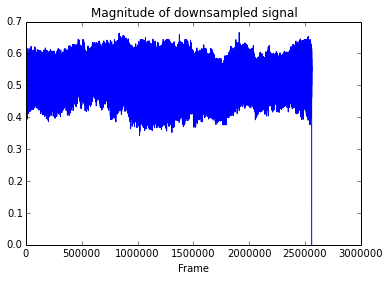

In [74]:
# Your code here:
plt.figure()
plt.plot(abs(ds_data))
plt.title('Magnitude of downsampled signal')
plt.xlabel('Frame')

In [75]:
limiter = lambda s: s/(abs(s) + 1e-6) 
ldata = limiter(ds_data)

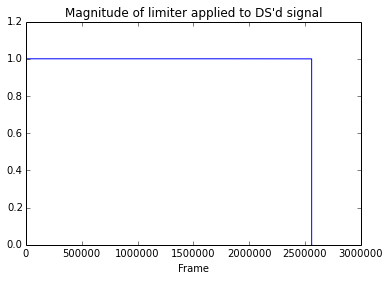

In [76]:
plt.figure()
plt.ylim([0,1.2])
plt.plot(abs(ldata))
plt.title('Magnitude of limiter applied to DS\'d signal')
plt.xlabel('Frame')

##### Discriminator
Assuming that $f_c=f_d$, after the limiter our signal is $ y_b(t)=e^{ j2\pi \Delta f \int_0^t x(\tau) d\tau }.$ To get $x(t)$ we can compute:

$$\left(\frac{d}{dt}y_b(t)\right)y_b^*(t) = j2\pi\Delta f \cdot x(t)\cdot e^{ j2\pi \Delta f \int_0^t x(\tau) d\tau }\cdot e^{  -j2\pi \Delta f \int_0^t x(\tau) d\tau } = j2\pi\Delta f \cdot x(t)$$

Which gives us our desired signal when we take the imaginary part of the result. 


We will need to design a differentiator filter, which its frequency response approximates the ideal frequency response, $H_{diff}(e^{jw}) = w$, of a differentiator. Since we are only going to demodulate up to 105KHz, we can have the differentiator roll of to zero after that. 

- Design an FIR differentiator filter with length 31 using the function `signal.remez` which implements an equi-ripple min-max optimal based filter design technique. It requires prescribing frequency bands and their corresponding frequency responses. We need to tell the function that it's a differentiator so it knows to match a linear frequency response within the band of interest. We will prescribe a linear frequency extending from 0-110KHz and then tapering to zero at the Nyquist frequency 120KHz. As we will learn later in class, since the filter is of even order (odd number of coefficients) and is antisymmetric, its Nyquist frequency must be zero!

Type `signal.remez?` for more information.

Specifically: 

    h_diff = signal.remez(31,[0.0,105000.0,120000.0,120000.0],[1.05/1.2,0],Hz = 240000.0, type='differentiator')
    
will try to get a linear frequency response from 0-105000 and zero amplitude at 120000.

- Plot the filter and its two sided magnitude frequency response (linear scale).




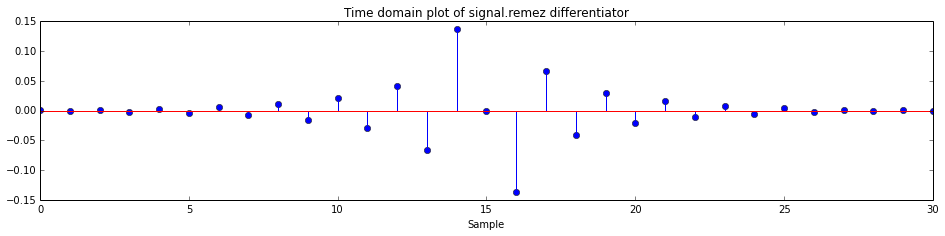

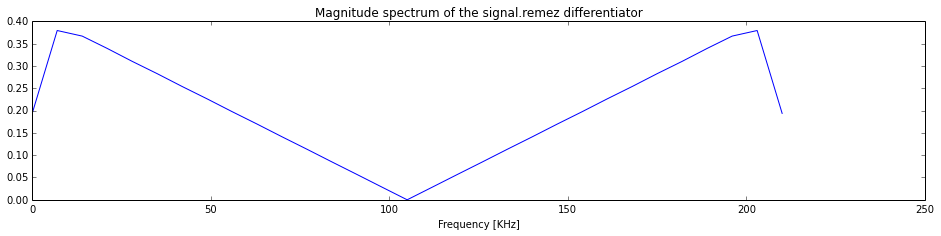

In [77]:
# Your code here:
h_diff = signal.remez(31, [0.0,105000.0,120000.0,120000.0],[1.05/1.2,0], Hz = 240000.0, type='differentiator')

H_diff = np.fft.fft(h_diff)
H_diff = np.fft.fftshift(H_diff)

f = np.linspace(0, 105000*2, len(H_diff))

# Plot I
width, height = figaspect(0.2)
fig=plt.figure(figsize=(width,height))
plt.stem(h_diff)
plt.title('Time domain plot of signal.remez differentiator');
plt.xlabel('Sample')

# Plot II
fig=plt.figure(figsize=(width,height))
plt.plot(f/1e3,np.abs(H_diff))
plt.title('Magnitude spectrum of the signal.remez differentiator')
plt.xlabel('Frequency [KHz]')

Demodulate the FM signal by first:
- Filter the signal with the differentiator 
- Multiply the result with the conjugate of the original signal
- Take the imaginary component

Note, that the default implementation of `signal.fftconvolve` will have a delay of 16 samples with respect to the original signal. **To avoid that, use the option `mode='same'`.**

Note, that after FM demodulating the signal should be real (by taking only the imaginary component) and hence only half the spectrum should be displayed. 

- Plot the spectrogram of the frequency demodulated signal and identify the mono audio, the pilot, the stereo and the RBDS signals. Note, that the RBDS signal may be too weak to detect or may need better spectral resolution. 
## Can you identify the subcarriers? KPFA has two subcarriers, one plays French Hatian radio and the other Punjabi. 
## Yes, there are two subcarriers: one around 70KHz, the other around 90KHz. Their signals are clearly different and look like speech.

In [78]:
diff = lambda s: signal.fftconvolve(s,
                                    signal.remez(31, [0.0,105000.0,120000.0,120000.0],[1.05/1.2,0], Hz = 240000.0, type='differentiator'),
                                    mode='same')

In [79]:
demod = lambda s: np.imag(np.conj(s)*diff(s))

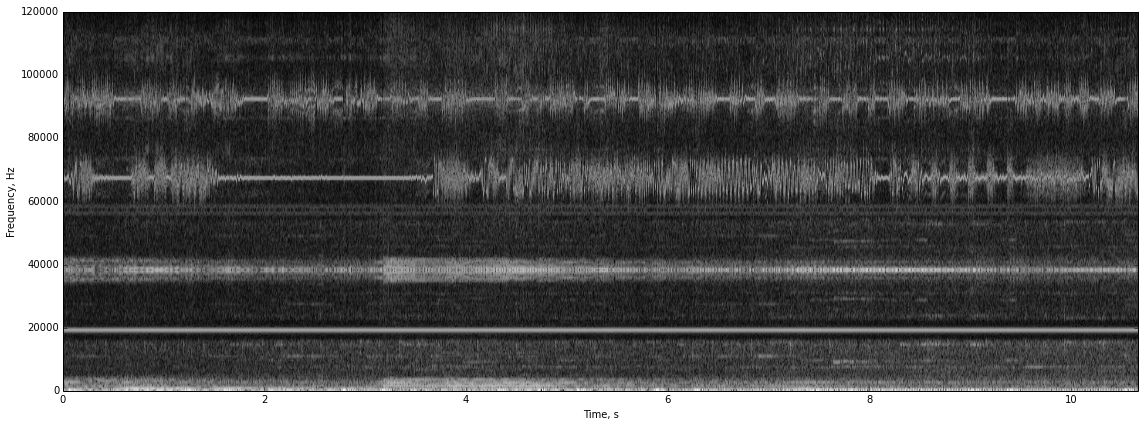

In [80]:
# Your code here:
demoded = demod(ldata)
myspectrogram_hann_ovlp(demoded, 512, fs/10, fc, dbf=30)

#### Play the mono  (Left  + Right Channel)


The mono signal covers the frequency range of 30Hz-16KHz. However, there are many other signals present. There's another problem. Our sampled signal is at a rate of 240KHz. The soundcard on most modern computers can only deal with a sampling rate of 48KHz. Similarly to the downsampling operation we did before, filter our signal and decimate it before being able to play it. 

- Design a 129 length FIR  Bandpass filter with a cuttoff frequency of 16KHz using the command:

    h = signal.firwin(129,16000.0,nyq=240000.0/2, window='hanning')

- Filter the signal and decimate by a factor of 5 to reduce the rate to 48KHz. Store the result in the a variable called `LPR` (Left + Right). Display the spectrogram of the `LPR`. Use a window length of 256. 





In [81]:
# Your code here:
h = signal.firwin(129,16000.0,nyq=240000.0/2, window='hanning')

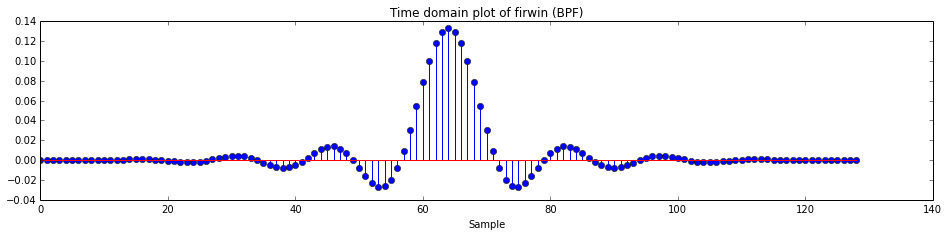

In [82]:
# Plot I
width, height = figaspect(0.2)
fig=plt.figure(figsize=(width,height))
plt.stem(h)
plt.title('Time domain plot of firwin (BPF)');
plt.xlabel('Sample')

In [92]:
filtered_data = signal.fftconvolve(demoded, h)

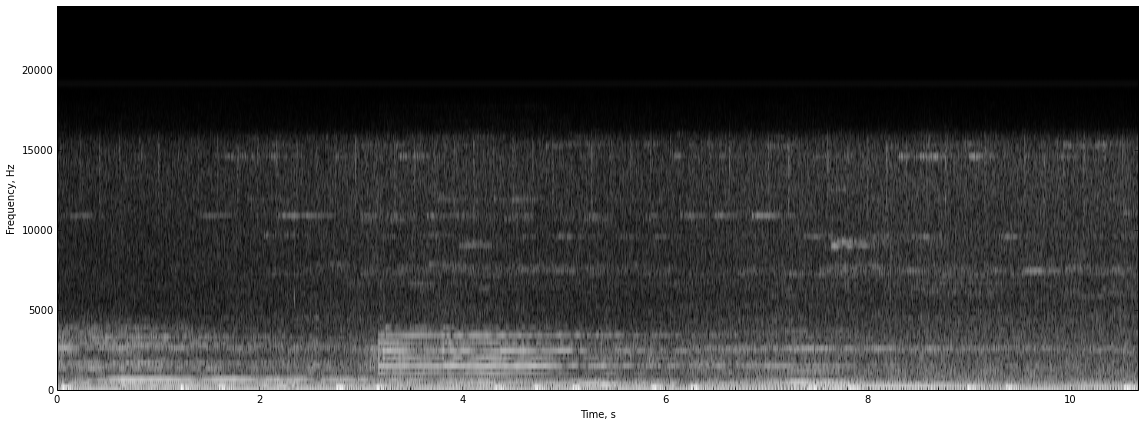

In [106]:
LPR = filtered_data[::5]
myspectrogram_hann_ovlp(LPR, 256, fs/50, fc, dbf=30)

#### Playing the Mono (Left + Right channel)

- Normalize `LPR` so it is in the range between -1 and 1. 
- Play it. 

Do you hear radio?



In [194]:
# Your code here:
LPR_ctr = LPR - np.median(LPR)
LPR_sc = LPR_ctr/max(abs(LPR_ctr.min()),LPR_ctr.max())

In [195]:
p = pyaudio.PyAudio()
play_audio( LPR_sc, p, int(fs/50) )
p.terminate()

In [122]:
# Write to wav file
write('fm_LR.wav', 48000, LPR_sc)

#### Demodulating the subcarriers

There are two other signals in the spectrum, centered at 67 kHz, and 92 kHz. These are subsidiary communications authorization (SCA) services. The FCC specifically doesn't regulate the FM band from 57 kHz up to 100 kHz, only requiring that whatever you transmit there doesn't interfere with the principle FM signal. For a long time this extra spectrum was used for Muzak (a generic name for elevator music), and other targeted FM signals. This has become less common with the advent of the internet, but there are still stations that use these channels. KPFA transmits a Hatian-French subchannel at 67 kHz, and a Punjabi subchannel at 92 kHz.

Oddly enough, the subchannels themselves are FM encoded. This is like the Russian Matrushka dolls, with one inside another. Fortunately, you have all the tools you need to decode these signals! 

First, demodulate the subcarrier to baseband. We will then low-pass to separate it from the other signals. Then, we will then downsample it to 48KHz, and then frequency demodulate again using the technique described above.

The entire system is described in the following diagram:

<center><img src="https://inst.eecs.berkeley.edu/~ee123/sp16/lab/lab3/fmdemod_sc.png" alt="FM" style="width: 800px;"/></center>


To demodulate the subcarrier to baseband -- or zero frequency we will need to:

1. create a time index `t` representing the samples of the signal
2. multiply the frequency demodulated signal in Task 5 with $e^{-2\pi j f_0 t}$ 

Task: Demodulate the frequency demodulated signal in Task 5 by $f_0=67.65$KHz and plot the spectrogram. Since the signal is now complex, you should plot both sides of the spectrum. The subcarrier should be placed at the DC frequency.

In [142]:
seconds = len(demoded)/(48000*5)
demod_by_f0 = lambda f0,d,s: d*np.exp(-2j*np.pi*f0*np.linspace(0,s,len(d)))
d67 = demod_by_f0(67650, demoded, seconds)

c


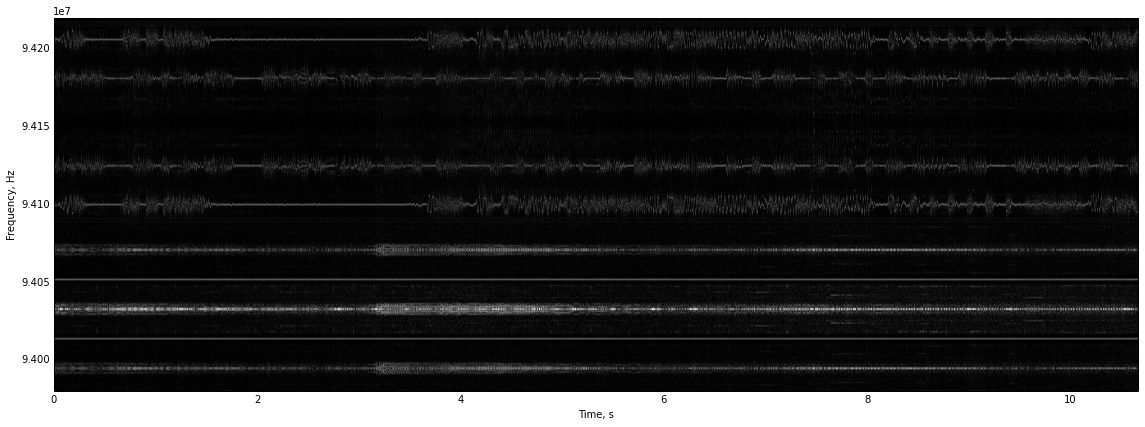

In [146]:
myspectrogram_hann_ovlp(d67, 512, fs/10, fc, dbf=30)

- Design a 128 tap low-pass filter with a bandwidth of $\pm 6$KHz in the passband. 
- Filter the signal and decimate by a factor of 5 to get a signal with a sampling rate of 48KHz. 
- Plot the spectrogram (make sure you adjusted the spectrogram to represent the new sampling rate!). 

## do you see aliasing? No, not here.

c


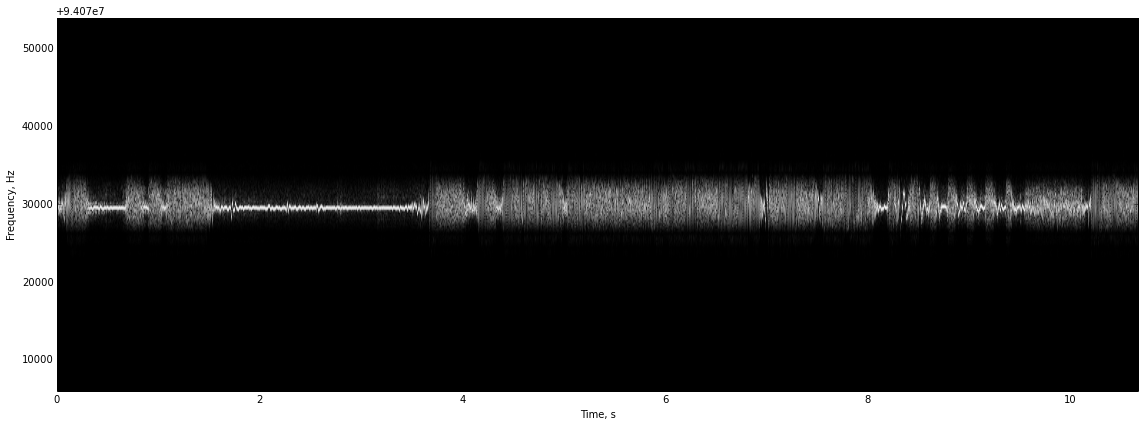

In [154]:
# Your code here: Didn't
h = signal.firwin(129,6000.0,nyq=2400000.0/2,window='hanning')
filtered67 = signal.fftconvolve(d67, h)[::5]
myspectrogram_hann_ovlp(filtered67, 256, fs/50, fc, dbf=30)

To frequency demodulate, you will need to apply a limiter as before. The discriminator should be implemented in the same way as before. However, you need to design a new filter which approximates a differentiator between $\pm$8KHz and then tapers to zero. Here's an example:

    h_diff = signal.remez(31,[0.0,8000.0,12000.0,24000],[8.0/24.0,0],Hz = 48000, type='differentiator')

- Perform the limiter operation
- Apply the discriminator using the differentiator filter method. 
- Low-pass the result with a 129 length FIR filter with cutoff of 5KHz to eliminate any residual high frequency noise. Don't forget that the sample rate is 48KHz! 
- Scale the result to be within $\pm1$ and play the audio. 
- Plot the spectrogram of the resulting signal. 

## Can you hear French Haitian? Yes! Faintly; the Punjabi station sounded clearer.

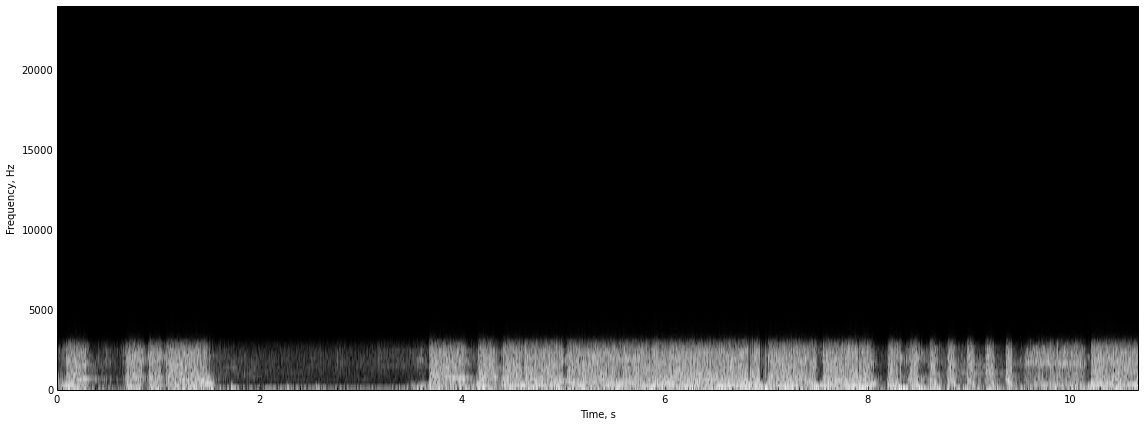

In [198]:
# Your code here:
diff = lambda s: signal.fftconvolve(s,
                                    signal.remez(31,[0.0,8000.0,12000.0,24000],[8.0/24.0,0],Hz = 48000, type='differentiator'),
                                    mode='same')

demod = lambda s: np.imag(np.conj(s)*diff(s))

ldata = limiter(filtered67)
demoded67 = demod(ldata)

h = signal.firwin(129,5000.0,nyq=48000,window='hanning')
lpdata = signal.fftconvolve(demoded67, h)
ctrd = lpdata - np.median(lpdata)
normed = ctrd/max(abs(ctrd.min()),ctrd.max())

myspectrogram_hann_ovlp(normed, 256, fs/50, fc, dbf=30)

p = pyaudio.PyAudio()
play_audio( normed, p, int(fs/50) )
p.terminate()

Repeat the procedure to play the subcarrier (Punjabi channel) at $f_0=92$ kHz

c


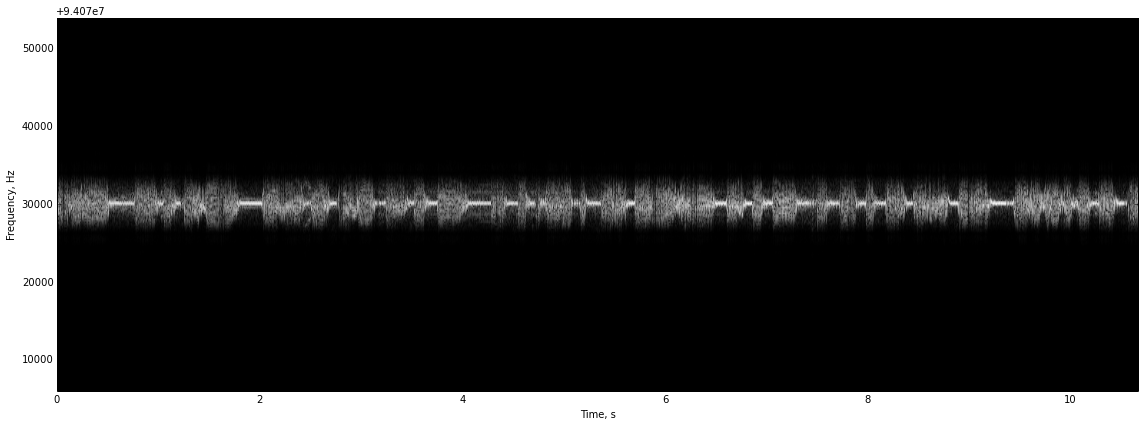

In [219]:
# Your code here:
seconds = len(demoded)/(48000*5)
demod_by_f0 = lambda f0,d,s: d*np.exp(-2j*np.pi*f0*np.linspace(0,s,len(d)))
d92 = demod_by_f0(92000, demoded, seconds)

# Your code here:
h = signal.firwin(129,6000.0,nyq=2400000.0/2,window='hanning')
filtered92 = signal.fftconvolve(d92, h)[::5]
myspectrogram_hann_ovlp(filtered92, 256, fs/50, fc, dbf=30)

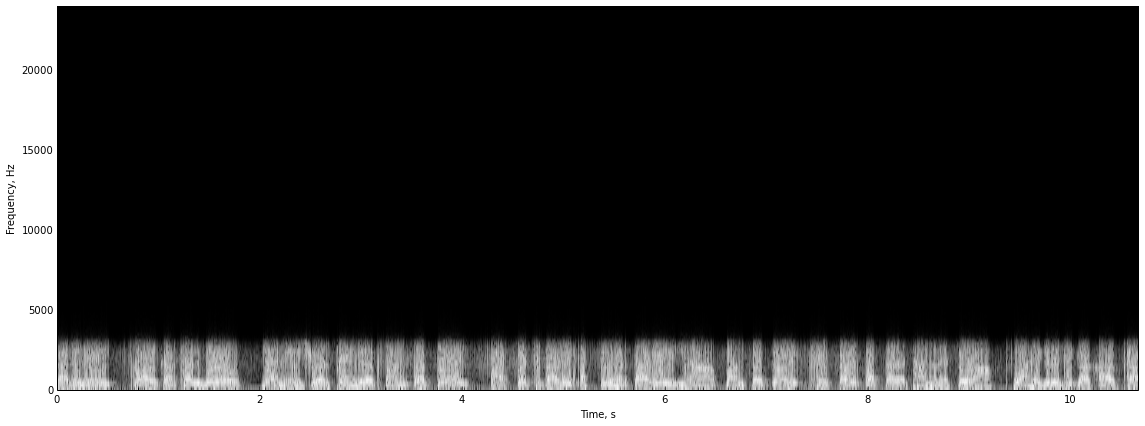

In [220]:
diff = lambda s: signal.fftconvolve(s,
                                    signal.remez(31,[0.0,8000.0,12000.0,24000],[8.0/24.0,0],Hz = 48000, type='differentiator'),
                                    mode='same')

demod = lambda s: np.imag(np.conj(s)*diff(s))

ldata = limiter(filtered92)
demoded92 = demod(ldata)

h = signal.firwin(129,5000.0,nyq=48000,window='hanning')
lpdata = signal.fftconvolve(demoded92, h)
ctrd = lpdata - np.median(lpdata)
normed = ctrd/max(abs(ctrd.min()),ctrd.max())
myspectrogram_hann_ovlp(normed, 256, fs/50, fc, dbf=30)

In [221]:
p = pyaudio.PyAudio()
play_audio( normed, p, int(fs/50) )
p.terminate()

In [222]:
write('punjabi.wav', 48000, normed)